In [1]:
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import fastmri
from fastmri.data import transforms
from fastmri.models.unet import Unet
from fastmri.models.varnet import *

import sigpy as sp
from sigpy import from_pytorch
import sigpy.plot as pl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import skimage.metrics

from dloader import genDataLoader

import matplotlib.pyplot as plt

In [2]:
# command line argument parser
parser = argparse.ArgumentParser(
    description = 'define parameters and roots for STL training'
)

parser.add_argument(
    '--scarcities', default=[0, 1], type=int, nargs='+',
    help='number of samples will be decreased by 1/2^N; match with roots'
    )

parser.add_argument(
    '--undersample', default=[6], type=int, nargs='+',
    help='undersampling factor of k-space'
    )

parser.add_argument(
    '--dataroots', nargs='+',
    help='paths of data files; match with scarcities',
#     required = True
)

parser.add_argument(
    '--epochs', default=100, type=int,
    help='number of epochs to run'
)

parser.add_argument(
    '--lr', default=0.001, type=float,
    help='learning rate'
)

parser.add_argument(
    '--modelpath', default='models/best-no-name.pt',
    help='path to save best model'
)

parser.add_argument(
    '--verbose', default=True, type=bool,
    help='if true, saves TensorFlow'
)

parser.add_argument(
    '--savefreq', default=5, type=int,
    help='how many epochs per saved recon image'
)

parser.add_argument(
    '--experimentname', default='unnamed_experiment'
    help='experiment name'
)


opt = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--scarcities SCARCITIES [SCARCITIES ...]]
                             [--undersample UNDERSAMPLE [UNDERSAMPLE ...]]
                             [--dataroots DATAROOTS [DATAROOTS ...]]
                             [--epochs EPOCHS] [--lr LR]
                             [--modelpath MODELPATH] [--verbose VERBOSE]
                             [--savefreq SAVEFREQ]
ipykernel_launcher.py: error: unrecognized arguments: -f /home_local/vliu/.local/share/jupyter/runtime/kernel-f4dc31ca-a7bf-40f5-8b7a-91e0a5ffc36c.json


SystemExit: 2

/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
# We can make one iteration block like this
class VarNetBlock(nn.Module):
    """
    This model applies a combination of soft data consistency with the input
    model as a regularizer. A series of these blocks can be stacked to form
    the full variational network.
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Module for "regularization" component of variational
                network.
        """
        super().__init__()

        self.model = model
        self.eta = nn.Parameter(torch.ones(1))

    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
    ) -> torch.Tensor:
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta
        model_term = self.sens_expand(
            self.model(self.sens_reduce(current_kspace, sens_maps)), sens_maps
        )

        return current_kspace - soft_dc - model_term

In [3]:
# now we can stack VarNetBlocks to make a unrolled VarNet (with 10 blocks)


class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """

    def __init__(
        self,
        num_cascades: int = 12,
        chans: int = 18,
        pools: int = 4,
    ):
        super().__init__()

        self.cascades = nn.ModuleList(
            [VarNetBlock(NormUnet(chans, pools)) for _ in range(num_cascades)]
        )
        
    def forward(
        self,
        masked_kspace: torch.Tensor, 
        mask: torch.Tensor,
        sens_maps: torch.Tensor
    ) -> torch.Tensor:
        
        kspace_pred = masked_kspace.clone()

        for cascade in self.cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, sens_maps)
        
        im_coil = fastmri.ifft2c(kspace_pred)
        im_comb = fastmri.complex_mul(im_coil, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        )
        
        return kspace_pred, im_comb

In [4]:
def count_parameters(model):
    return sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )



def test_result(im_fs: torch.Tensor, im_us: torch.Tensor) -> np.ndarray:

    with torch.no_grad():
        im_us = from_pytorch(im_us.cpu().detach(),iscomplex = True)
        im_fs = from_pytorch(im_fs.cpu().detach(), iscomplex = True)
        im_us = np.abs(im_us).squeeze()
        im_fs = np.abs(im_fs).squeeze()
        
        im_us = sp.resize(im_us, [360, 320])
        im_fs = sp.resize(im_fs, [360, 320])
        
        out_cat = np.concatenate((im_us, im_fs),1)
        error_cat = np.concatenate((im_us, im_us),1)
        error_cat = np.abs(error_cat - out_cat) * 5
        
        out_cat = np.concatenate((error_cat, out_cat,), axis=0)
        out_cat = out_cat * 20
        
    return np.flip(out_cat)


def plot_quadrant(im_fs, im_us):
    fig = plt.figure()
    plt.imshow(test_result(im_fs, im_us), cmap = 'gray')
    plt.close(fig)
    return fig


def param_dict(lr, epochs, undersampling, scarcities):
    params = {}
    params['lr'] = lr
    params['epochs'] = epochs
    
    for i in range(len(undersampling)):
        params[f'accerlation_{i}'] = undersampling[i]
    
    for i in range(len(scarcities)):
        params[f'scarcity_{i}'] = scarcities[i]
    return params


def write_tensorboard(avg_cost, model)            
    #write to tensorboard ###opt###
    for epoch in range(len(avg_cost))
        writer.add_scalars(
            'losses/l1', {
                'train' : avg_cost[epoch, 0],
                'val' : avg_cost[epoch, 4],
            }, 
            epoch
        )

        writer.add_scalars(
            'metrics/ssim', {
                'train' : avg_cost[epoch, 1],
                'val' : avg_cost[epoch, 5],
            }, 
            epoch
        )

        writer.add_scalars(
            'metrics/psnr', {
                'train' : avg_cost[epoch, 2],
                'val' : avg_cost[epoch, 6],
            }, 
            epoch
        )

        writer.add_scalars(
            'metrics/nrmse', {
                'train' : avg_cost[epoch, 3],
                'val' : avg_cost[epoch, 7],
            }, 
            epoch
        )

    writer.add_text(
        'parameters', 
        f'{count_parameters(single_task_model)} parameters'
    )
    
    writer.add_hparams(
        param_dict(0.001, 2, [6], [0]), 
        {'hparam/loss':avg_cost[0, 0]}
    )

In [5]:
def criterion(im_fs: torch.Tensor, im_us: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device for fast computation
    '''
    
    # use l1 loss between two images
    criterion = nn.L1Loss()
    
    # can add more fancy loss functions here later
    
    return criterion(im_us, im_fs)

def metrics(im_fs: torch.Tensor, im_us: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device for fast computation
    '''

    # change to ndarray
    im_us = transforms.tensor_to_complex_np(im_us.cpu().detach())
    im_fs = transforms.tensor_to_complex_np(im_fs.cpu().detach())
    
    # convert complex nums to magnitude
    im_us = np.absolute(im_us)
    im_fs = np.absolute(im_fs)
    
    im_us = im_us.reshape(
        (im_us.shape[2], im_us.shape[3])
    )
    
    im_fs = im_fs.reshape(
        (im_fs.shape[2], im_fs.shape[3])
    )
    
    # psnr
    psnr = skimage.metrics.peak_signal_noise_ratio(
        im_fs, 
        im_us, 
        data_range = np.max(im_fs) - np.min(im_fs)
    )
    
    #nrmse
    nrmse = skimage.metrics.normalized_root_mse(im_fs, im_us)
    
    # ssim
    # normalize 0 to 1
    im_fs -= np.min(im_fs)
    im_fs /= np.max(im_fs)
    im_us -= np.min(im_us)
    im_us /= np.max(im_us)
    
    ssim = skimage.metrics.structural_similarity(im_fs, im_us, data_range = 1)
    
    return ssim, psnr, nrmse

In [13]:
"""
=========== Universal Single-task Trainer =========== 
code modified from https://github.com/lorenmt/mtan/blob/master/im2im_pred/utils.py
"""


def single_task_trainer(
    train_loader, val_loader,
    contrasts, ratios,
    single_task_model, device, 
    optimizer, scheduler,
    writer,
    opt = 0, total_epochs=2 ###opt###
):
    
    train_batch = len(train_loader)
    val_batch = len(val_loader)
    
    best_val_loss = np.infty
    
    # contains info for all epochs
    avg_cost = np.zeros(
        [total_epochs, 8 * len(contrasts)], 
        dtype = np.float32
    )
    
    for epoch in range(total_epochs):
        # contains info for single batch of single epoch
        cost = np.zeros(8, dtype = np.float32)

        # train data
        single_task_model.train()
        train_dataset = iter(train_loader)
    
        for _ in range(train_batch):
            kspace, mask, sens, im_fs, contrast = next(train_dataset)
            contrast = contrast[0]
            kspace, mask = kspace.to(device), mask.to(device)
            sens, im_fs = sens.to(device), im_fs.to(device)

            optimizer.zero_grad()
            _, im_us = single_task_model(kspace, mask, sens) # forward pass
            loss = criterion(im_fs, im_us)
            loss.backward()
            optimizer.step()
            
            # L1 loss for now
            cost[0] = loss.item() 
            # ssim, psnr, nrmse
            cost[1], cost[2], cost[3] = metrics(im_fs, im_us)
            
            # refer to Notion avg_cost table for description
            offset = contrasts[contrast] # offset
            avg_cost[
                epoch, 4 * offset : 4 * offset + 4
            ] += cost[:4] / ratios[contrast]
            
            avg_cost[epoch, -2] += cost[0] / train_batch

            
        # validation data
        single_task_model.eval()
        with torch.no_grad():
            test_dataset = iter(val_loader)

            for val_idx in range(val_batch):
                kspace, mask, sens, im_fs, contrast = next(test_dataset)
                contrast = contrast[0]
                kspace, mask = kspace.to(device), mask.to(device)
                sens, im_fs = sens.to(device), im_fs.to(device)

                _, im_us = single_task_model(kspace, mask, sens) # forward pass
                loss = criterion(im_fs, im_us)
                # L1 loss for now
                cost[4] = loss.item()
                # ssim, psnr, nrmse
                cost[5], cost[6], cost[7] = metrics(im_fs, im_us)
                
                # refer to Notion avg_cost table for description
                offset = contrasts[contrast] # contrast as an int
                avg_cost[
                    epoch, 
                    4 * len(contrasts) + 4 * offset : 4 * len(contrasts) + 4 * offset + 4
                ] += cost[:4] / ratios[contrast]
                
                avg_cost[epoch, -1] += cost[4] / val_batch
                
               # visualize reconstruction every few epochs
                if val_idx == 18 and epoch % 1 == 0: ###opt###
                    writer.add_figure(
                        'recons', 
                        plot_quadrant(im_fs, im_us),
                        epoch, close = True,
                    )
                
                
        # early stopping        
        if avg_cost[epoch, -1] < best_val_loss:
            best_val_loss = avg_cost[epoch, -1]
            torch.save(single_task_model.state_dict(), 'models/best-test.pt') ###opt###
            

        scheduler.step()
        
        print(f'''
        >Epoch: {epoch + 1:04d}
        TRAIN: loss {avg_cost[epoch, 0]:.4f} | ssim {avg_cost[epoch, 1]:.4f} | psnr {avg_cost[epoch, 2]:.4f} | nrmse {avg_cost[epoch, 3]:.4f} 
        TEST: loss {avg_cost[epoch, 4]:.4f} | ssim {avg_cost[epoch, 5]:.4f} | psnr {avg_cost[epoch, 6]:.4f} | nrmse {avg_cost[epoch, 7]:.4f}
        
        ''')
        
        
        
    # write to tensorboard
    ###opt###
    if False: ###opt###
        write_tensorboard(avg_cost, single_task_model)   
        


In [7]:
# datasets
dataset_names = {
    'div_coronal_pd' : 0,
    'div_coronal_pd_fs' : 1
}

basedirs = [
    f'/mnt/dense/vliu/summer_dset/{dataset_name}'
    for dataset_name in dataset_names.keys()
]
basedirs

['/mnt/dense/vliu/summer_dset/div_coronal_pd',
 '/mnt/dense/vliu/summer_dset/div_coronal_pd_fs']

In [8]:
train_dloader = genDataLoader(
    [f'{basedir}/Train' for basedir in basedirs], # choose randomly
    [4, 4] # downsample
)

val_dloader = genDataLoader(
    [f'{basedir}/Val' for basedir in basedirs], # choose randomly
    [3, 3], # downsample
    shuffle = False,
)

# other inputs to STL wrapper
writer = SummaryWriter()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
varnet = VarNet().to(device)

optimizer = torch.optim.Adam(varnet.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [14]:
single_task_trainer(
    train_dloader[0], val_dloader[0], 
    dataset_names, train_dloader[1], # contrasts and ratios dicts
    varnet, device, 
    optimizer, scheduler,
    writer,
    opt = 0, total_epochs=3
)
writer.flush()
writer.close()


        >Epoch: 0001
        TRAIN: loss 1.3225 | ssim 30.0744 | psnr 1116.2870 | nrmse 7.7962 
        TEST: loss 1.9718 | ssim 28.7720 | psnr 1232.9995 | nrmse 9.1265
        
        

        >Epoch: 0002
        TRAIN: loss 1.2328 | ssim 30.6215 | psnr 1145.9652 | nrmse 7.1595 
        TEST: loss 1.8857 | ssim 29.5542 | psnr 1256.2714 | nrmse 8.5400
        
        

        >Epoch: 0003
        TRAIN: loss 1.1091 | ssim 31.6622 | psnr 1177.7019 | nrmse 6.5410 
        TEST: loss 1.8171 | ssim 29.8190 | psnr 1279.6337 | nrmse 8.0094
        
        


In [33]:
###############################################
# trying to get mr images onto tensorboard, unsuccessful
###############################################

dloader = iter(val_dloader[2])
varnet = VarNet() 
varnet_gpu = varnet.to('cuda:3')
Nepoch = 1
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)



for epoch in range(Nepoch):
    loss_epoch = 0
    idx = 0
    for kspace, mask, sens, im_true, contrast in dloader:
        kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:3'), mask.to('cuda:3'), sens.to('cuda:3'), im_true.to('cuda:3')
        optimizer.zero_grad() 
        _, im_est_gpu = varnet_gpu(kspace_gpu,mask_gpu,sens_gpu)
        loss = criterion(im_true_gpu, im_est_gpu)
        loss.backward() # this performs the backprop
        optimizer.step() # this performs the gradient update
        loss_epoch += loss.item()
        idx += 1
        if idx == 17:
            break
    print('epoch:{}/{} Mean Loss: {}'.format(epoch, Nepoch, loss_epoch / len(dloader))) # report loss for end of the epoch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0436f3bf70>
Traceback (most recent call last):
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home_local/vliu/miniconda3/envs/multiTask/lib/pyth

ValueError: not enough values to unpack (expected 5, got 2)

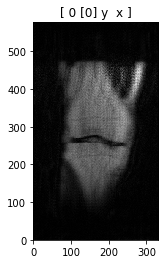

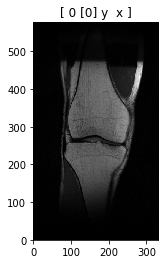

In [13]:
###############################################
# trying to get mr images onto tensorboard, unsuccessful
###############################################

%matplotlib inline
# Let's look at the final produced image
im_est = transforms.tensor_to_complex_np(im_est_gpu.cpu().detach())
im_true = transforms.tensor_to_complex_np(im_true_gpu.cpu().detach())

pl.ImagePlot(im_est) # this is est image
pl.ImagePlot(im_true) # this is true image

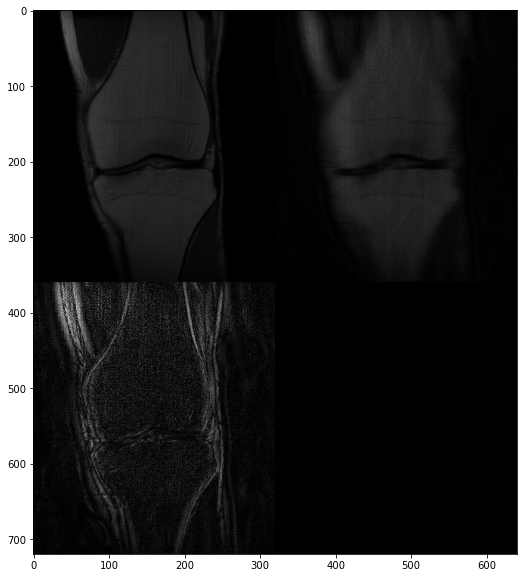

In [20]:
my_fig = plt.imshow(test_result(im_true_gpu, im_est_gpu), cmap = 'gray')

In [21]:
my_fig.set_cmap('nipy_spectral')

In [23]:
type(my_fig)

matplotlib.image.AxesImage

In [38]:
def plot_quadrant(im_fs, im_us):
    fig = plt.figure()
    plt.imshow(test_result(im_fs, im_us), cmap = 'gray')
    plt.close(fig)
    return fig

In [39]:
fig = plot_quadrant(im_true_gpu, im_est_gpu)

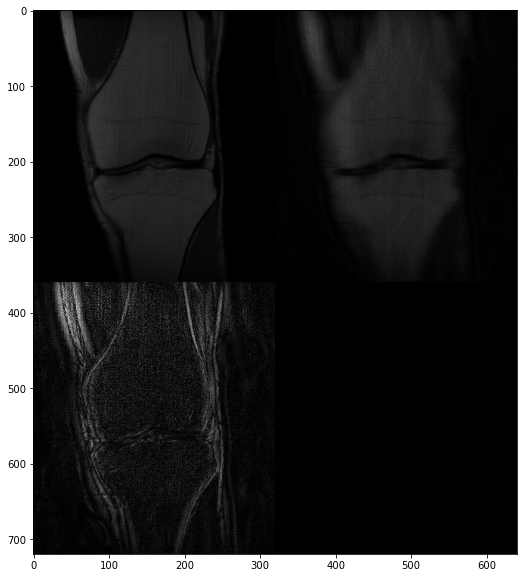

In [40]:
fig

In [70]:
import numpy as np
import sigpy as sp
import os
import h5py
import pathlib  # pathlib is a good library for reading files in a nested folders

from torch.utils.data import DataLoader, Dataset
import torch

import fastmri  # We will also use fastmri library
# use for generating undersampling mask, transforming tensors
from fastmri.data import subsample, transforms

# This is how you can make a custom dataset class

class MRIDataset(Dataset):

    def __init__(
        self, roots, scarcities, seed,
        center_fractions=[0.06, 0.06, 0.06], accelerations=[4, 5, 6]
    ):
        self.rng = np.random.default_rng(seed)
        self.examples = []
        self.ratios = {}
        self.contrasts = {}
        for idx, root in enumerate(roots):
            # update contrast dict
            contrast = root.split('/')[-2]
            if contrast not in self.contrasts:
                self.contrasts[contrast] = len(self.contrasts)
                
            Files = list(pathlib.Path(root).glob('*.h5'))
            # subsample files
            Files = self.subset_sample(Files, scarcities[idx])
            self.ratios[contrast] = len(Files)

            # individual slices
            for fname in Files:
                h5file = h5py.File(fname, 'r')
                kspace = h5file['kspace']
                nsl = kspace.shape[0]  # get number of slices
                self.examples += [(fname, sl, contrast) for sl in range(nsl)]

        self.mask_func = subsample.EquispacedMaskFunc(
            center_fractions=center_fractions, accelerations=accelerations
        )

    def subset_sample(self, Files, scarcity):
        '''
        decrease number of Files by 1/2^{scarcity} in a reproducible manner
        '''
        for _ in range(scarcity):
            if int(len(Files) / 2) > 0:
                Files = self.rng.choice(Files, int(
                    len(Files) / 2), replace=False)
        return list(Files)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        fname, sl, contrast = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
        kspace = kspace / 10  # divide by 10 because the values are too large
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_true = np.sum(im_coil * np.conj(sens), axis=0)

        mask = self.mask_func(list(im_true.shape) + [1])[..., 0]
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask  # undersampled kspace
        mask = np.expand_dims(mask, axis=-1)

        # Now transform everything to tensor.
        # The complex kspace will be changed to [real, imag] in the final axis
        masked_kspace = transforms.to_tensor(masked_kspace)
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_true = np.expand_dims(im_true, axis=0)
        im_true = transforms.to_tensor(im_true)

        return masked_kspace, mask.byte(), sens, im_true, contrast


def genDataLoader(roots, scarcities, seed=123, shuffle=True):
    dset = MRIDataset(roots=roots, scarcities=scarcities, seed=seed)
    return (dset.contrasts, dset.ratios, DataLoader(dset, batch_size=1, shuffle=shuffle, num_workers=16))



In [67]:
val_dloader = genDataLoader(
    [f'{basedir}/Val' for basedir in basedirs], # choose randomly
    [3, 3], # downsample
    shuffle = False,
)

In [68]:
dloader = iter(val_dloader[2])
_, _, _, _, contrast = next(dloader)


['div_coronal_pd']

In [71]:
contrast[0]

'div_coronal_pd'